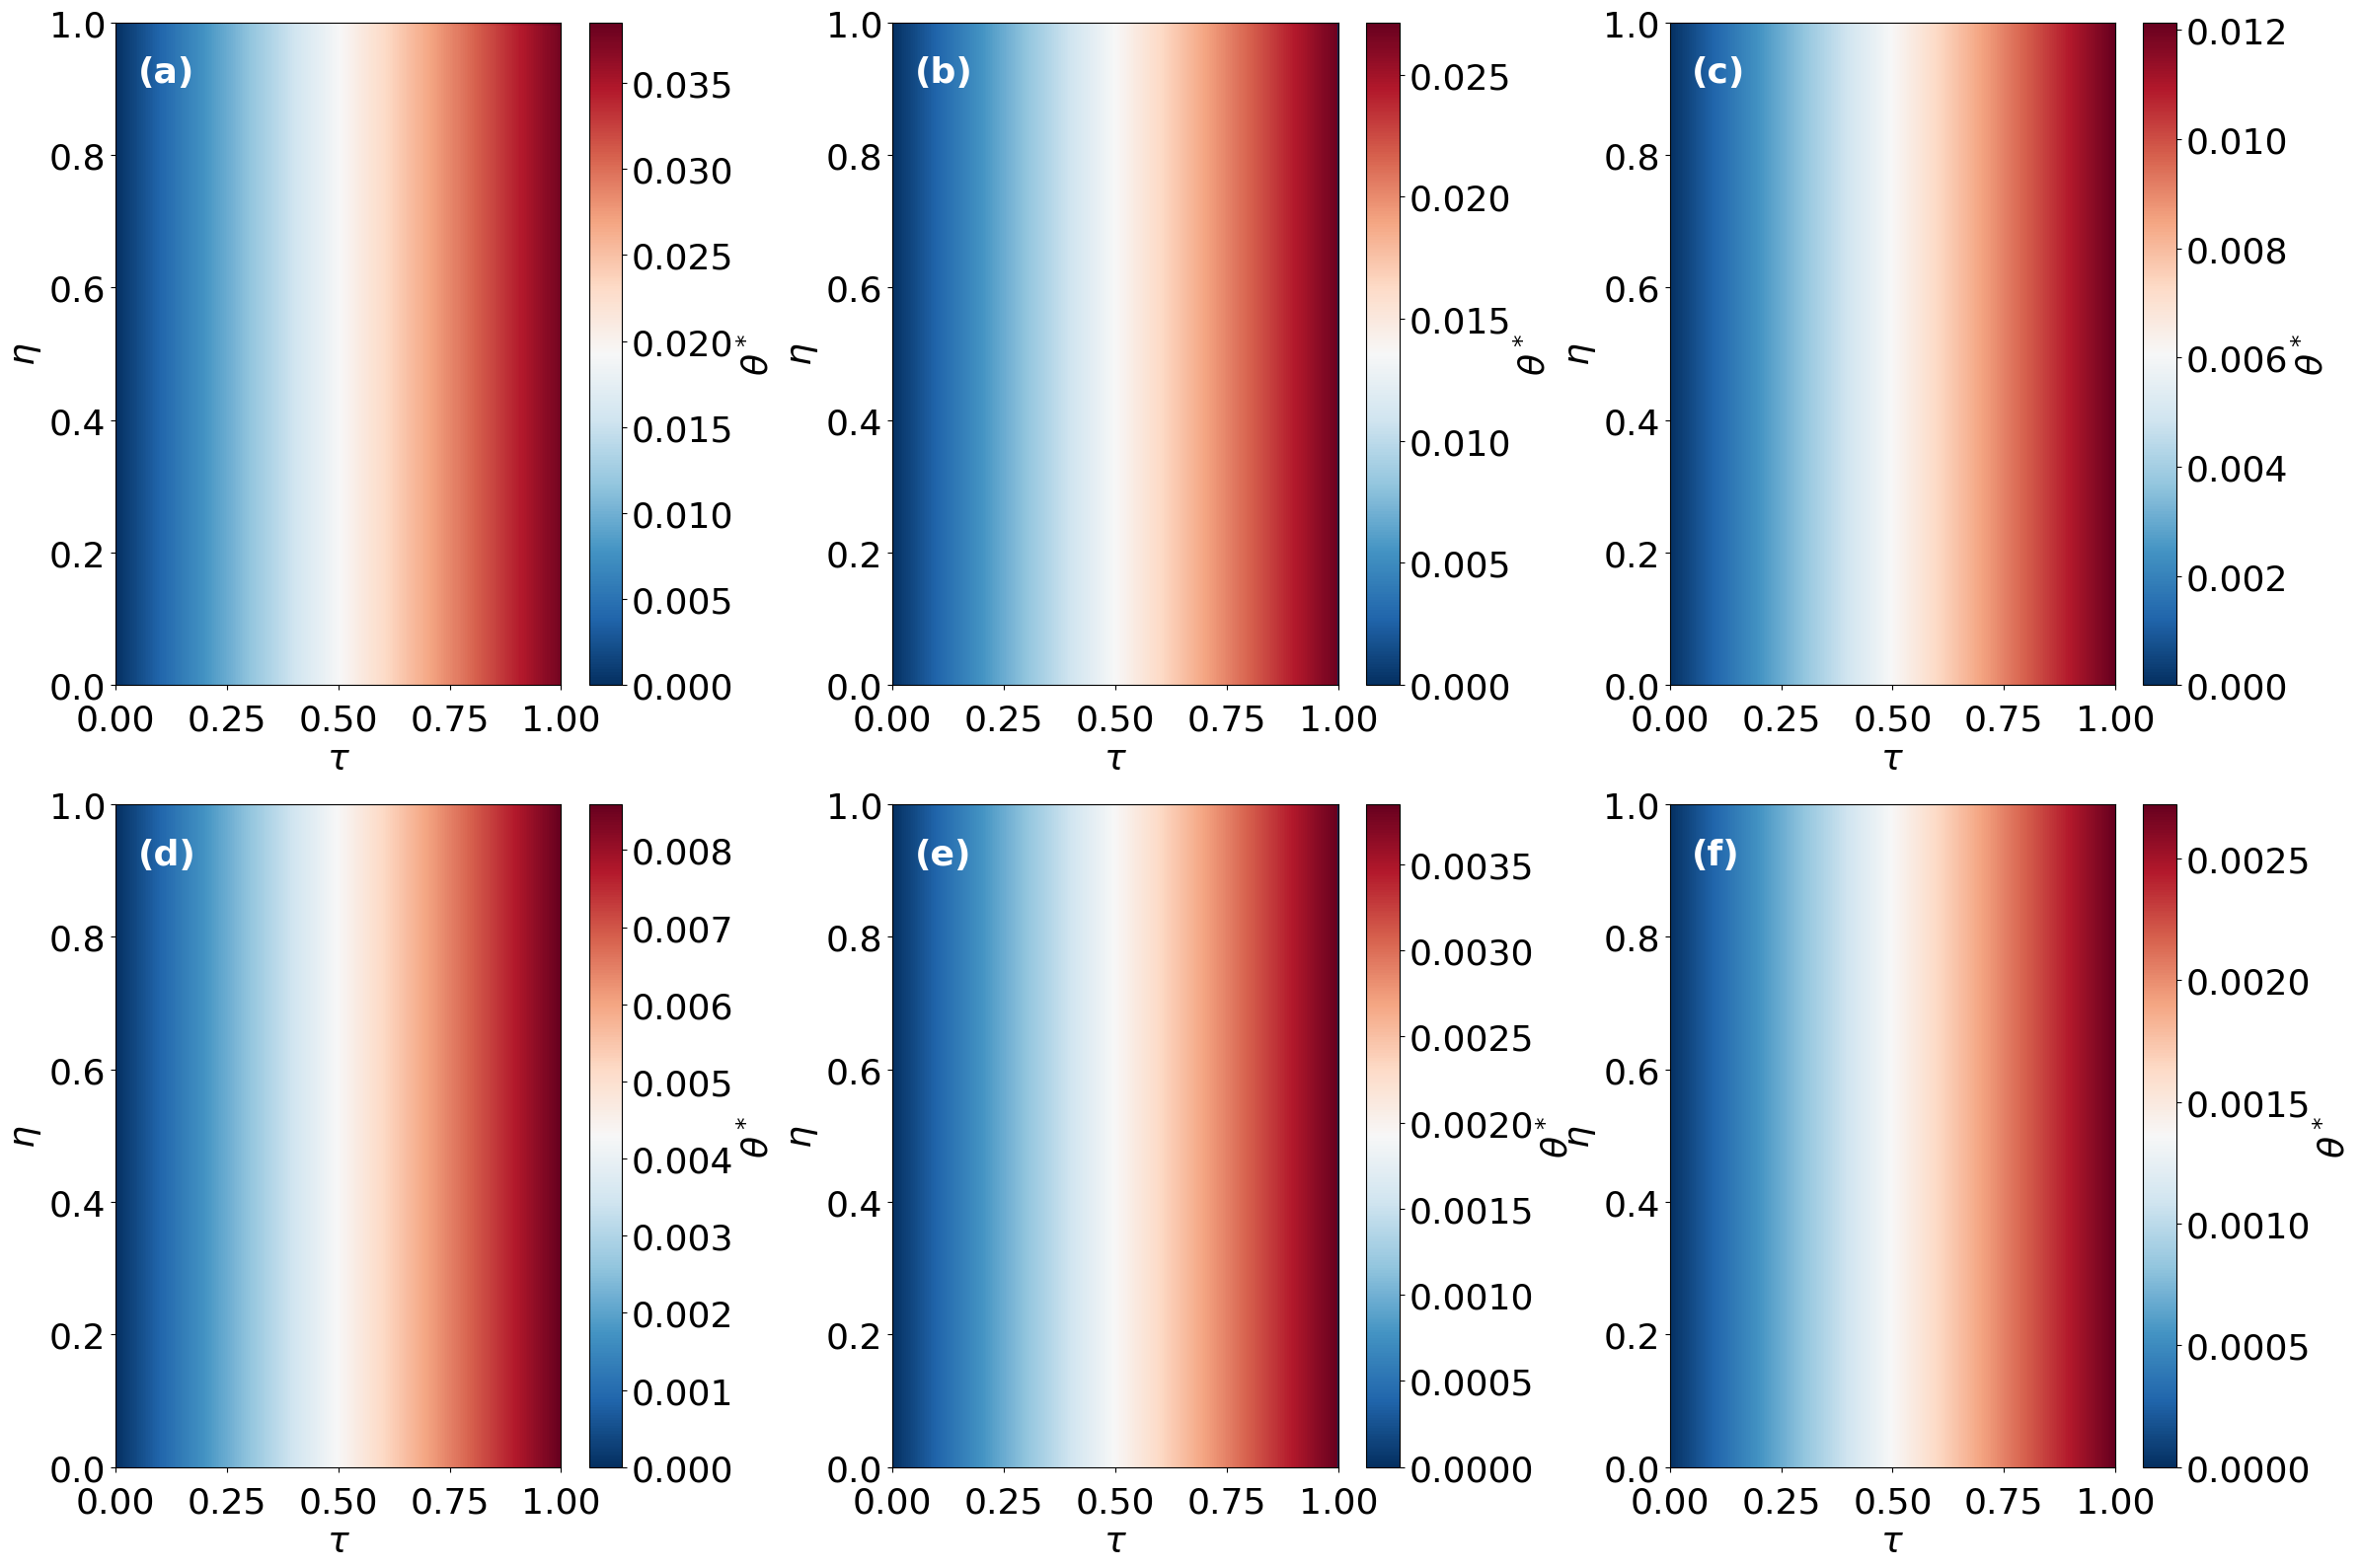

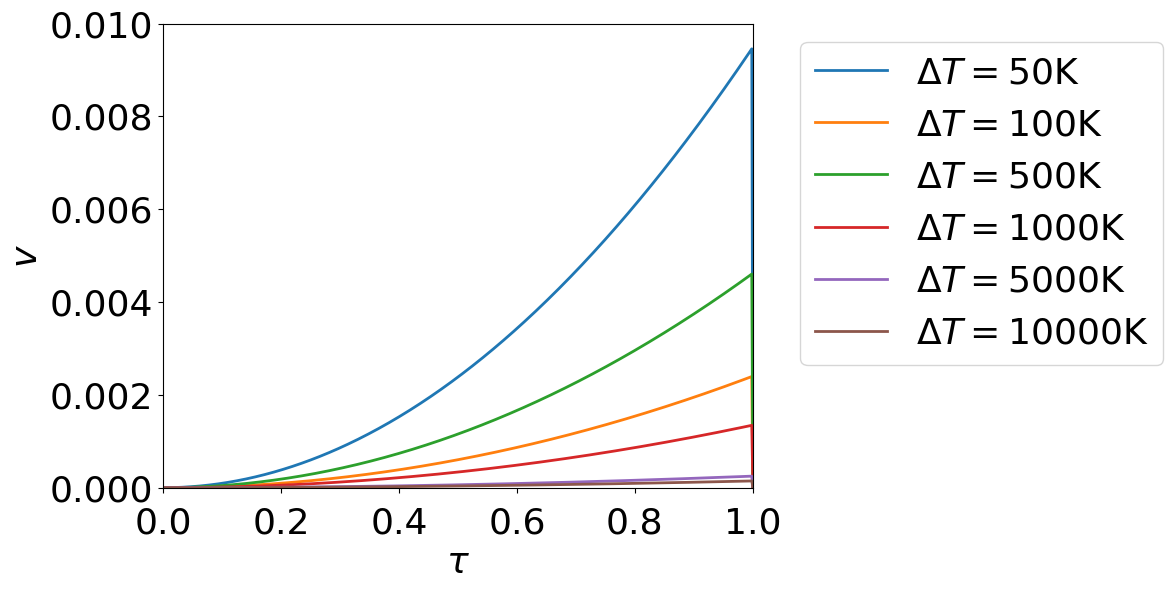

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import FormatStrFormatter

# Definir las constantes
g = 9.8 # gravedad [m/s^2]
p_atm = 101325 # Presion atmosferica [Pa]
beta = 3.67e-3 # Coeficiente de expansion termica [1/K]
lambda_f = 0.04 # Coeficiente de friccion [adimensional]
alpha = 2.2e-5 # Coeficiente de difusividad [m^2/s]
rho_0 = 1.0 # Densidad [kg/m^3]
Cp = 1.012 # Capacidad calorifica [J/(kg K)]
k = 0.024 # Conductividad termica [W/(m K)]
nu = 1.71e-5 # Viscosidad [Pa s]

# Parametros directos
R = 10.0 # Radio de la tuberia [m]
L = 100.0 # Longitud de la tuberia [m]
D = 2 * R # Diametro de la tuberia [m]
Delta_T = 50 # diferencia de temperaturas [K]

# Definicion de parametros indirectos
def parametros(D, L, Delta_T):
    h = 1.42 * (Delta_T/L)**(1/4) # coeficiente de transmision de calor por conveccion (recopilatorio)
    phi = 1/ (beta * Delta_T)
    Ri = 2 * rho_0**2 * g * beta * L * Cp**2 * Delta_T /  h**2 # Numero de Richardson
    Ra = rho_0**2 * g * beta * Cp * D**2 * Delta_T / (16 * nu * h) # Numero de Rayleigh
    LAMBDA = L/D # Relacion de aspecto
    delta = alpha * h / (L**2 * rho_0 * g * beta * Cp * Delta_T)
    return h, phi, Ri, Ra, LAMBDA, delta

def f(v, phi, Ri, Ra, LAMBDA):
    return phi + Ri**-1 * v**2 + Ra**-1 * v - 1 + (v/LAMBDA) * (1 - math.exp(-LAMBDA/v))

def f_prime(v, Ri, Ra, LAMBDA):
    return 2 * Ri**-1 * v + Ra**-1 + (1/LAMBDA) * (1 - (1 + 1/v)*math.exp(-LAMBDA/v))

def newton_raphson(phi, Ri, Ra, LAMBDA, v0=0.1, tol=1e-6, max_iter=100):
    v = v0
    for i in range(max_iter):
        v_new = v - f(v, phi, Ri, Ra, LAMBDA) / f_prime(v, Ri, Ra, LAMBDA)
        if abs(v_new - v) < tol:
            return v_new
        v = v_new
    return v  # Returns the last approximation if it doesn't converge

# Calculo y representacion
def calculo_rep(Ra, Ri, delta, v_e, LAMBDA):
    # Definicion de variables y condiciones iniciales
    M = 256 # Numero de puntos en la direccion vertical
    N = 512 # Numero de puntos en la direccion temporal
    eta = np.linspace(0, 1, M)  # Coordenada vertical adimensional
    tau = np.linspace(0, 1, N)  # Coordenada temporal adimensional
    deta = (eta[-1] - eta[0])/M
    dtau = (tau[-1] - tau[0])/N 
    v = np.zeros(N)  # Velocidad adimensional
    theta_star = np.zeros((M, N))  # Temperatura adimensional

    # Condiciones iniciales
    v[0] = 0.0  # Velocidad inicial cero

    # Simulacion numerica
    for t in range(1, N-1):


        # Calculo de la velocidad en el instante i+1 a partir de la presion en eta = 0 del instante anterior:
        v[t] = v[t-1] + deta * (- Ra**-1 * v[t-1] + theta_star[0, t-1]/v_e)

        # Calculo de las distribuciones de temperatura y presion en el espacio para el instante i+1:
        for x in range(M-1):
            
            dtheta_deta = (theta_star[x+1, t-1] - theta_star[x, t-1]) / deta
            d2theta_deta2 = (theta_star[x+1, t-1] - 2 * theta_star[x, t-1] + theta_star[x-1, t-1]) / deta**2
            theta_star[x, t] = theta_star[x, t-1] - dtau * (2 * Ri**-1 * v_e * v[t] * dtheta_deta
                                                - delta * d2theta_deta2
                                                + 2 * Ri**-1 * LAMBDA * (theta_star[x, t-1] - 1))
    return v, theta_star, eta, tau

# Lista de diferencias de temperatura
delta_T_list = [50, 100, 500, 1000, 5000, 10000]

# Crear la figura con un tamano especifico
fig, axs = plt.subplots(2, 3, figsize=(24, 16))

# Aplanar la matriz de subplots para facilitar la iteracion
axs = axs.flatten()

# Graficar y recopilar datos
for i, delta_T in enumerate(delta_T_list):
    h, phi, Ri, Ra, LAMBDA, delta = parametros(D, L, delta_T)
    v_e = newton_raphson(phi, Ri, Ra, LAMBDA, v0=0.1, tol=1e-6, max_iter=100)
    v, theta_star, eta, tau = calculo_rep(Ra, Ri, delta, v_e, LAMBDA)  
    
    # Crear el mapa de calor
    im = axs[i].pcolormesh(tau, eta, theta_star, cmap='RdBu_r', shading='auto')
    
    # Configurar los ejes y etiquetas
    axs[i].set_xlabel(r'$\tau$', fontsize=26)
    axs[i].set_ylabel(r'$\eta$', fontsize=26)
    axs[i].set_xlim(0, 1)
    axs[i].set_ylim(0, 1)
    axs[i].tick_params(axis='both', which='major', labelsize=26)
    axs[i].tick_params(axis='x', which='major', pad=10)
    
    # Anadir barra de color
    cbar = fig.colorbar(im, ax=axs[i])
    cbar.set_label(r'$\theta^*$', fontsize=26)
    cbar.ax.tick_params(labelsize=26)
    
    # Anadir etiqueta (a, b, c, d, e, f) en la esquina superior izquierda
    axs[i].text(0.05, 0.95, f'({chr(97 + i)})', transform=axs[i].transAxes, 
                fontsize=26, fontweight='bold', va='top', color='white')

# Ajustar el diseno
plt.tight_layout()

# Mostrar la grafica
plt.show()

# Grafica de velocidad
fig, ax = plt.subplots(figsize=(12, 6))

for delta_T in delta_T_list:
    h, phi, Ri, Ra, LAMBDA, delta = parametros(D, L, delta_T)
    v_e = newton_raphson(phi, Ri, Ra, LAMBDA, v0=0.1, tol=1e-6, max_iter=100)
    v, theta_star, eta, tau = calculo_rep(Ra, Ri, delta, v_e, LAMBDA)  
    ax.plot(tau, v, linewidth=2, label=r'$\Delta T =$' f'{delta_T:.0f}K')

ax.set_xlabel(r'$\tau$', fontsize=26)
ax.set_ylabel(r'$v$', fontsize=26)
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.01)
ax.tick_params(axis='both', which='major', labelsize=26)
ax.tick_params(axis='x', which='major', pad=10)

ax.legend(fontsize=26, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
